In [1]:
# Import libraries
import boto3
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib
from io import BytesIO, StringIO
from datetime import datetime, timezone, date
import geopandas as gpd
import contextily as cx

import matplotlib.colors as colors

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/victoriaford/anaconda3/envs/histobs/lib/python3.11/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.9.1dev-CAPI-1.14.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [6]:
color_dict = {
    'ASOSAWOS':'#2faf4f',
    'CAHYDRO':'#556b2f',
    'CDEC':'#8b4513',
    'CIMIS':'#191970',
    'CNRFC':'#3cb371',
    'CRN':'#9acd32',
    'CW3E':'#daa520',
    'CWOP':'#8b008b',
    'HADS':'#ff4500',
    'HNXWFO':'#00ced1',
    'HOLFUY':'#ffff00',
    'HPWREN':'#0000cd',
    'LOXWFO':'#00ff00',
    'MAP':'#00ff7f',
    'MARITIME':'#dc143c',
    'MTRWFO':'#b0c4de',
    'NCAWOS':'#ff00ff',
    'NDBC':'#db7093',
    'NOS-NWLON':'#eee8aa',
    'NOS-PORTS':'#6495ed',
    'OtherISD':'#ff1493',
    'RAWS':'#7b68ee',
    'SCAN':'#ffa07a',
    'SGXWFO':'#ee82ee',
    'SHASAVAL':'#920000',
    'SNOTEL':'#24ff24',
    'VCAPCD':'#ffff6d'
}

In [ ]:
## Current counts of # of stations with observations per variable
# tas: 13,891
# tdps: 1,040
# tdps_derived: 10,670
# ps: 1,087
# psl: 738
# ps_altimeter: 8,712
# pr: 9,171
# pr_5min: 555
# pr_1h: 1,913
# pr_24h: 6,808
# pr_localmid: 5,433
# hurs: 10,797
# sfcwind: 11,780
# sfcwind_dir: 11,720
# rsds: 6,344

In [3]:
# Read in all stations
s3 = boto3.resource("s3") 
s3_cl = boto3.client('s3')

bucket_name = "wecc-historical-wx"

def var_fullname(var):
    """Returns the full name of variable for title purposes"""
    if var == "tas":
        var_title = "Air temperature ({})".format(var)
    if "tdps" in var:
        var_title = "Dewpoint temperature ({})".format(var)
    elif var == "hurs":
        var_title = "Relative humidity ({})".format(var)
    elif var == "rsds":
        var_title = "Radiation ({})".format(var)
    elif var == "sfcwind":
        var_title = "Surface wind speed ({})".format(var)
    elif var == "sfcwind_dir":
        var_title = "Surface wind direction ({})".format(var)
    elif "pr" in var:
        var_title = "Precipitation ({})".format(var)
    elif "ps" in var and "td" not in var:
        var_title = "Air pressure ({})".format(var)
    
    return var_title

In [4]:
def gdf_setup(var, shapepath):
    # Read in all stations
    s3 = boto3.resource("s3") 
    s3_cl = boto3.client('s3')
    
    bucket_name = "wecc-historical-wx"
    
    obj = s3_cl.get_object(Bucket=bucket_name, Key="2_clean_wx/temp_clean_all_station_list.csv")
    body = obj['Body'].read()
    df_all = pd.read_csv(BytesIO(body), encoding='utf8')
    
    # ------------------------------------------------------------------------------------------------------------
    # Make a geodataframe
    gdf = gpd.GeoDataFrame(df_all, geometry=gpd.points_from_xy(df_all.longitude, df_all.latitude))
    gdf.set_crs(epsg=4326, inplace=True) # Set CRS

    # Project data to match base tiles.
    gdf_wm = gdf.to_crs(epsg=3857) # Web mercator

    # Read in geometry of continental US.
    us = gpd.read_file(shapepath)

    # Remove territories, AK, HI
    rem_list = ["HI", "AK", "MP", "GU", "AS", "PR", "VI"]
    us = us.loc[us.STUSPS.isin(rem_list) == False]

    # Use to clip stations
    us = us.to_crs(epsg = 3857)
    gdf_us = gdf_wm.clip(us)
    gdf_us = gdf_us.sort_values(['network'])

    # Setting color
    gdf_us['Color'] = gdf_us['network'].map(ho_colors)

    # Subsetting based on variable
    new_gdf = gdf_us.loc[gdf_us[str(var)+'_nobs'] > 0]
    
    return new_gdf

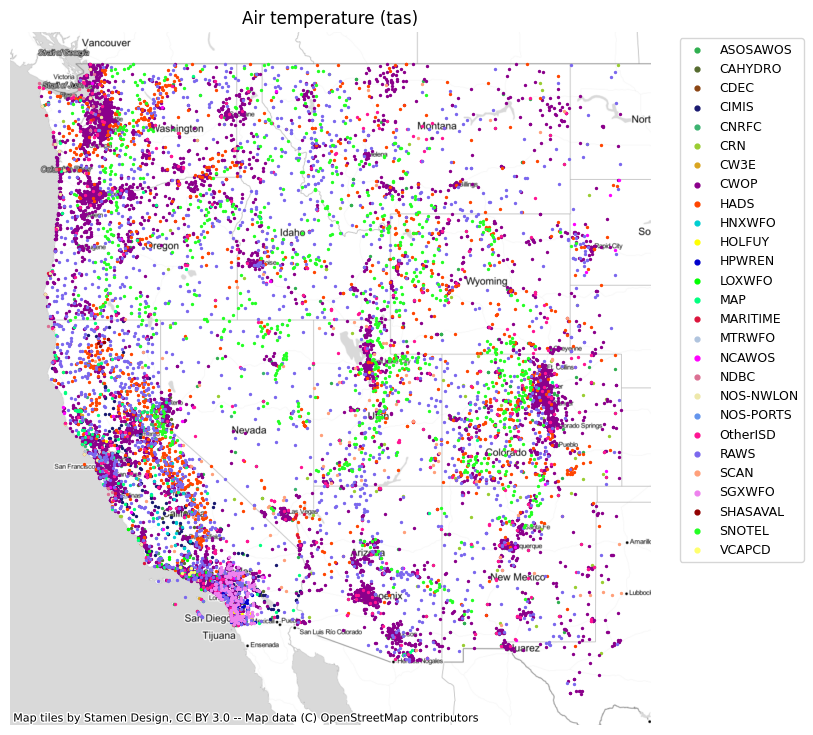

<Figure size 640x480 with 0 Axes>

In [33]:
# Run function - generate station map
def single_var_map(var, shapepath):
    
    # grab gdf per variable
    gdf = gdf_setup(var, shapepath)
        
    # figure global settings
    fig, ax = plt.subplots(figsize=(9,9))
    a=1 # alpha
    ms=2 # markersize
    
    # plot by network with correct legend color
    for ctype, data in gdf.groupby('network'):
        color = color_dict[ctype]
        data.plot(color=color,
                  markersize=ms, 
                  alpha=a,
                  ax=ax, 
                  label=ctype)

    cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite);

    # legend handling
    l = ax.legend(bbox_to_anchor=(1.25, 1), prop={'size':9}, frameon=True)
    for i in range(len(l.legend_handles)):
        l.legend_handles[i]._sizes = [12] # sets size of points in legend to be more visible

    # set title
    vartitle = var_fullname(var)
    ax.set_title(vartitle, fontsize=12)
    ax.set_axis_off()
    
    # in notebook, show figure
    plt.show()
    
    # save to AWS
    img_data = BytesIO()
    plt.savefig(img_data, format='png', bbox_inches='tight')
    img_data.seek(0)

    bucket = s3.Bucket(bucket_name)
    bucket.put_object(Body=img_data, ContentType='image/png', Key="2_clean_wx/clean_station_{}.png".format(var))
    
# Run function to produce plots        
shapepath = "s3://wecc-historical-wx/0_maps/tl_2021_us_state.shp"
single_var_map(var = 'tas', shapepath = shapepath)

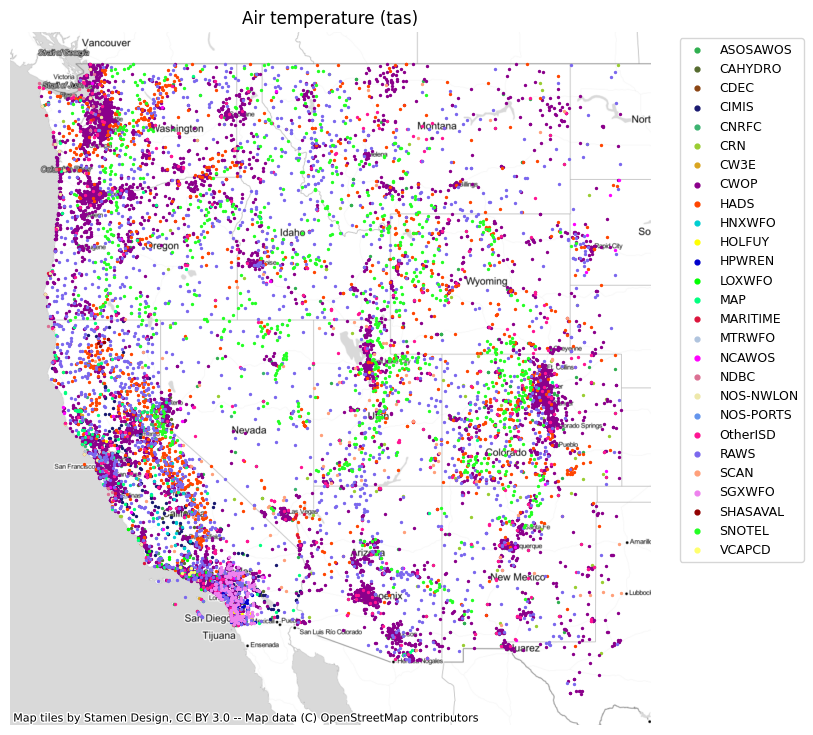

<Figure size 640x480 with 0 Axes>

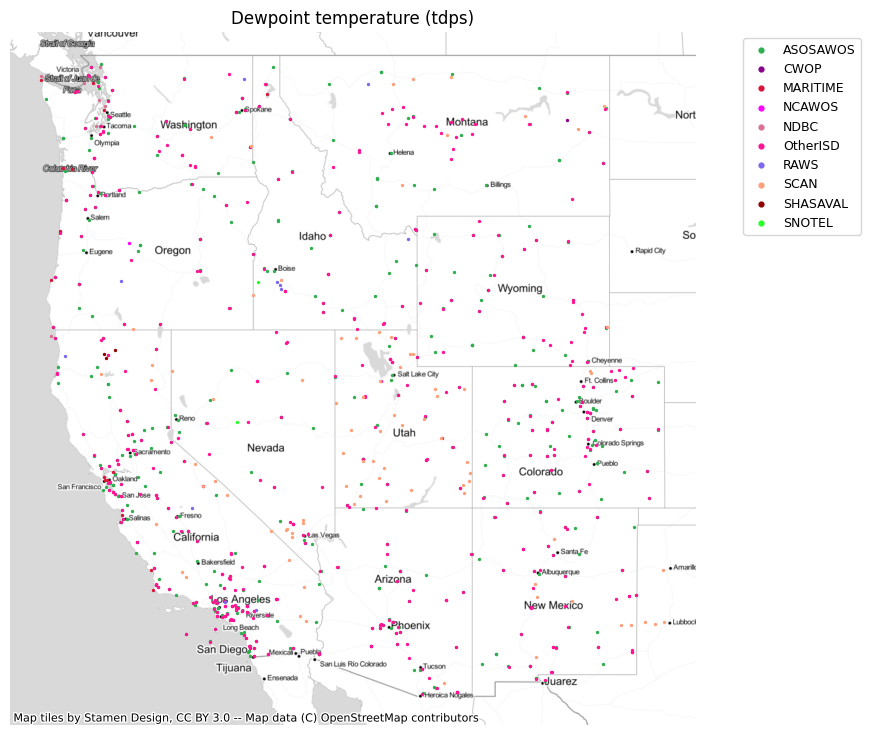

<Figure size 640x480 with 0 Axes>

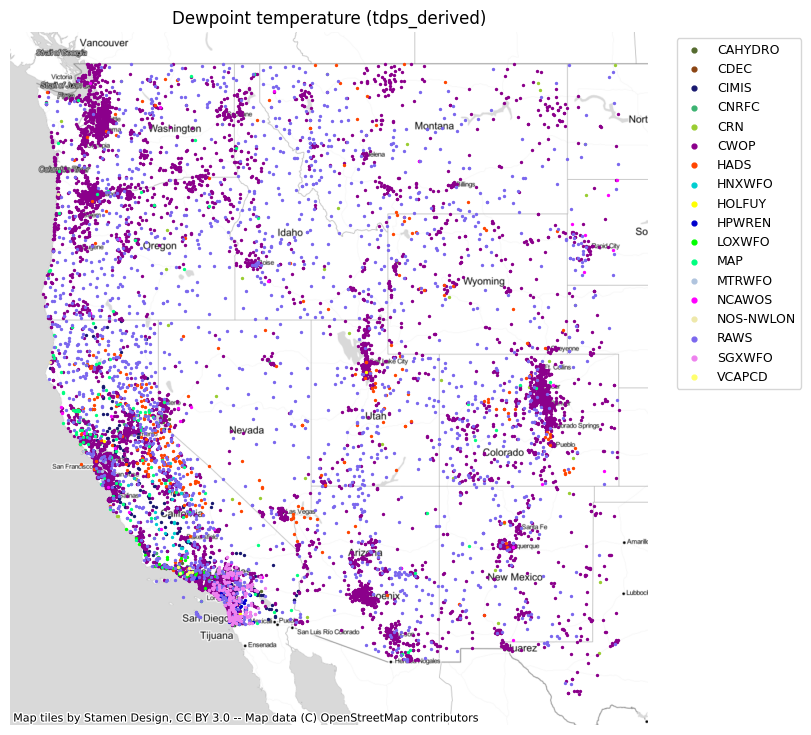

<Figure size 640x480 with 0 Axes>

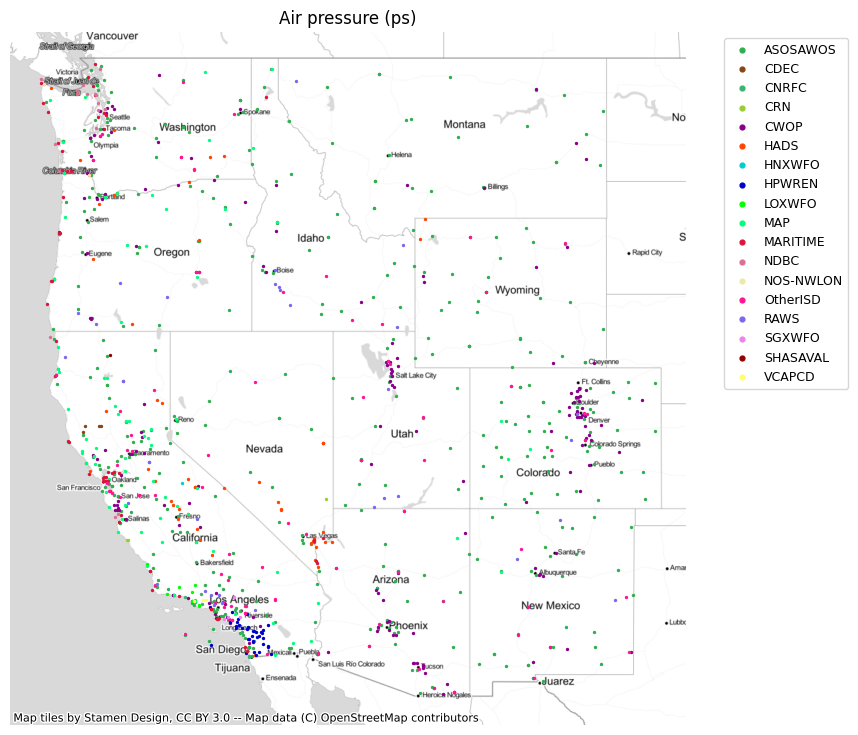

<Figure size 640x480 with 0 Axes>

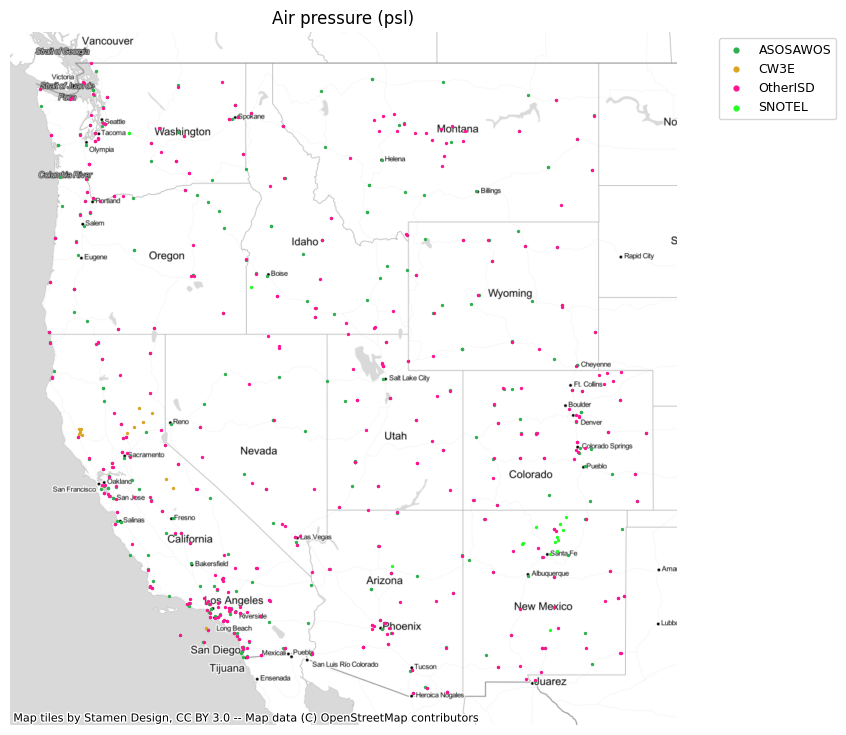

<Figure size 640x480 with 0 Axes>

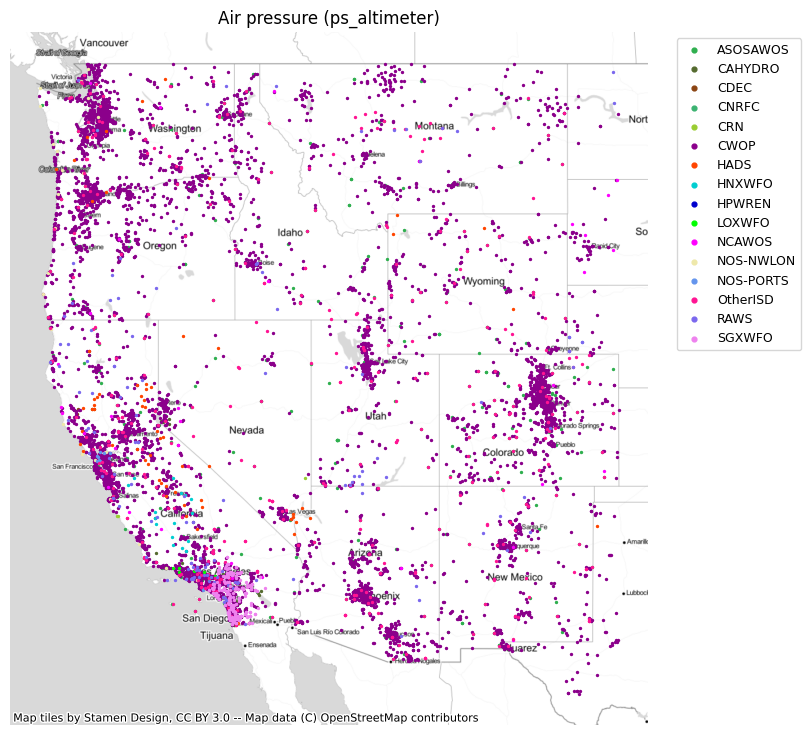

<Figure size 640x480 with 0 Axes>

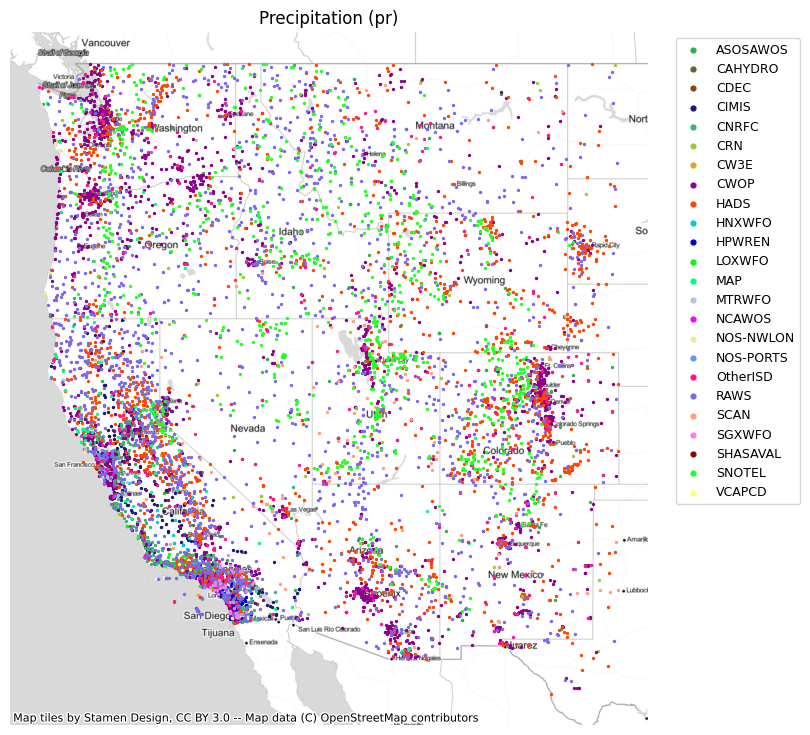

<Figure size 640x480 with 0 Axes>

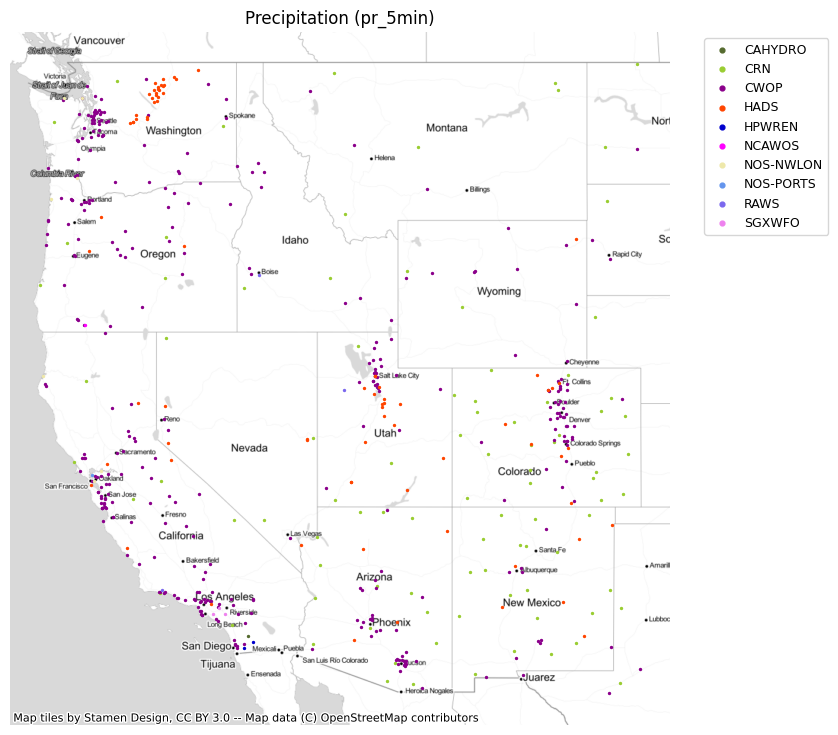

<Figure size 640x480 with 0 Axes>

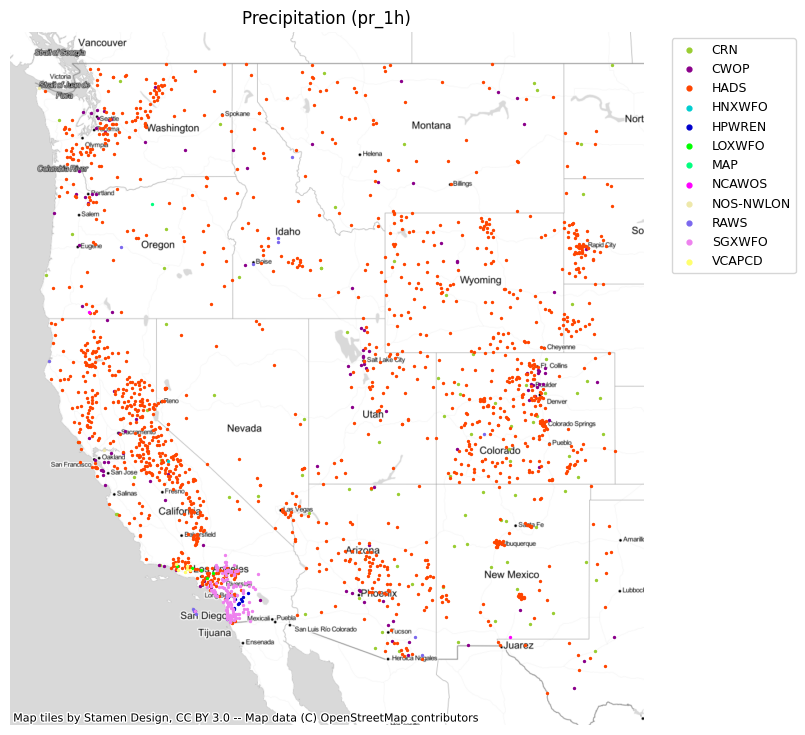

<Figure size 640x480 with 0 Axes>

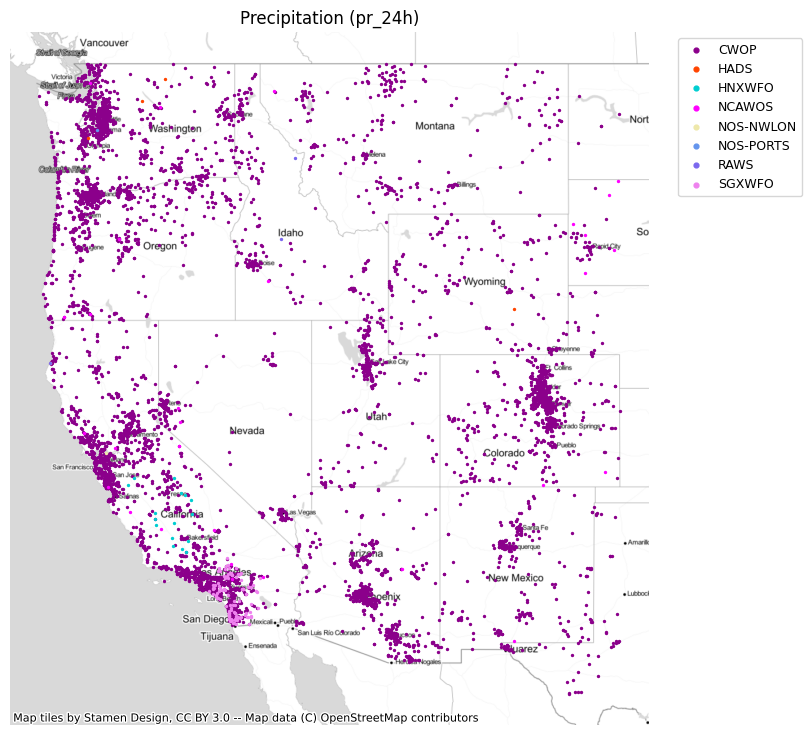

<Figure size 640x480 with 0 Axes>

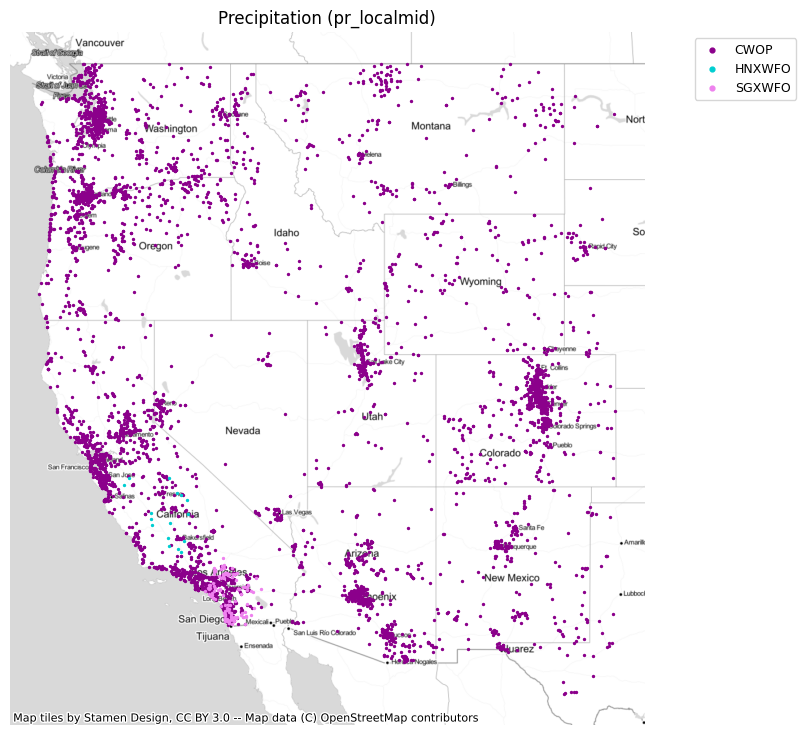

<Figure size 640x480 with 0 Axes>

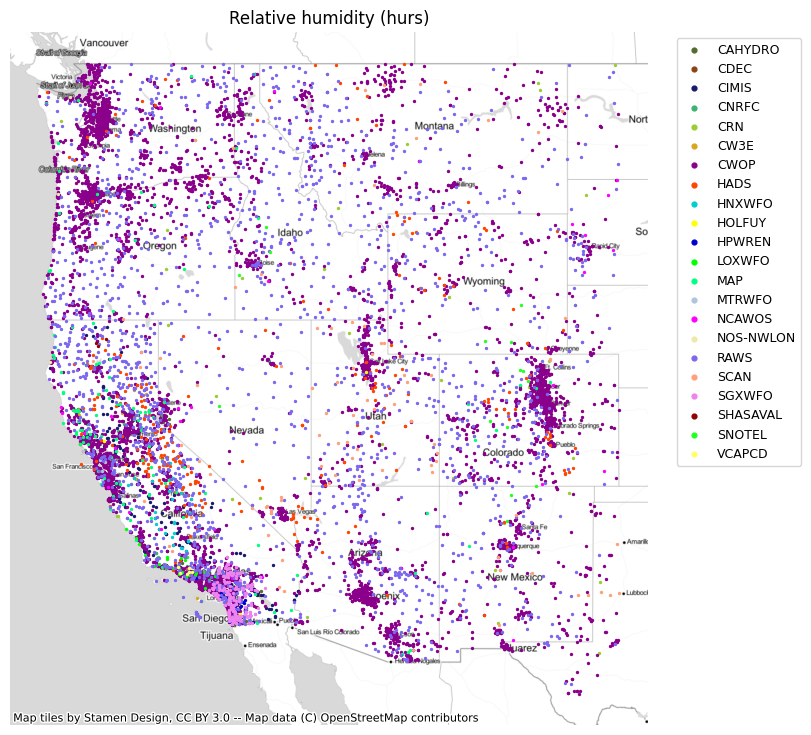

<Figure size 640x480 with 0 Axes>

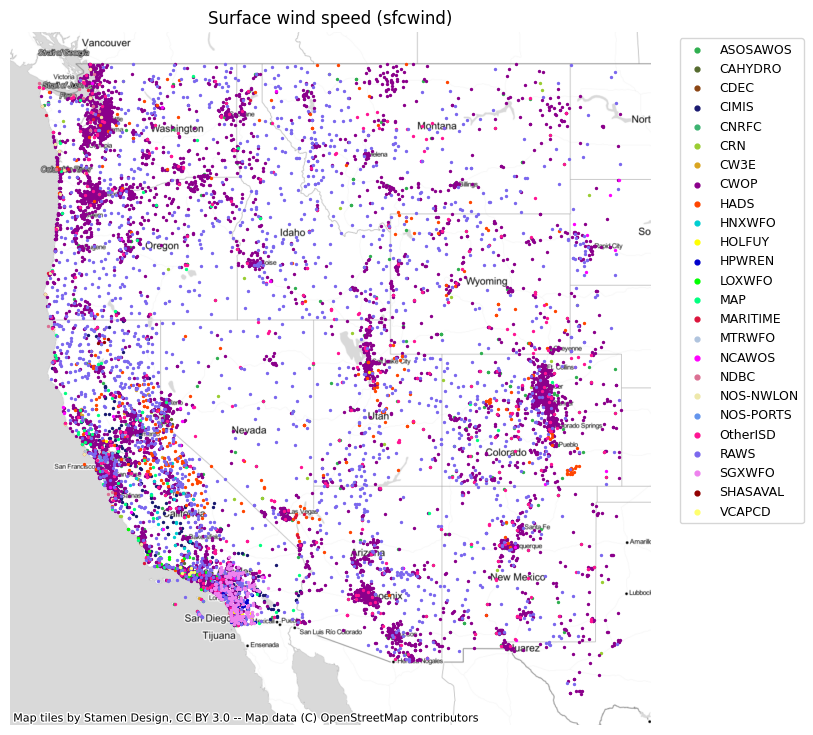

<Figure size 640x480 with 0 Axes>

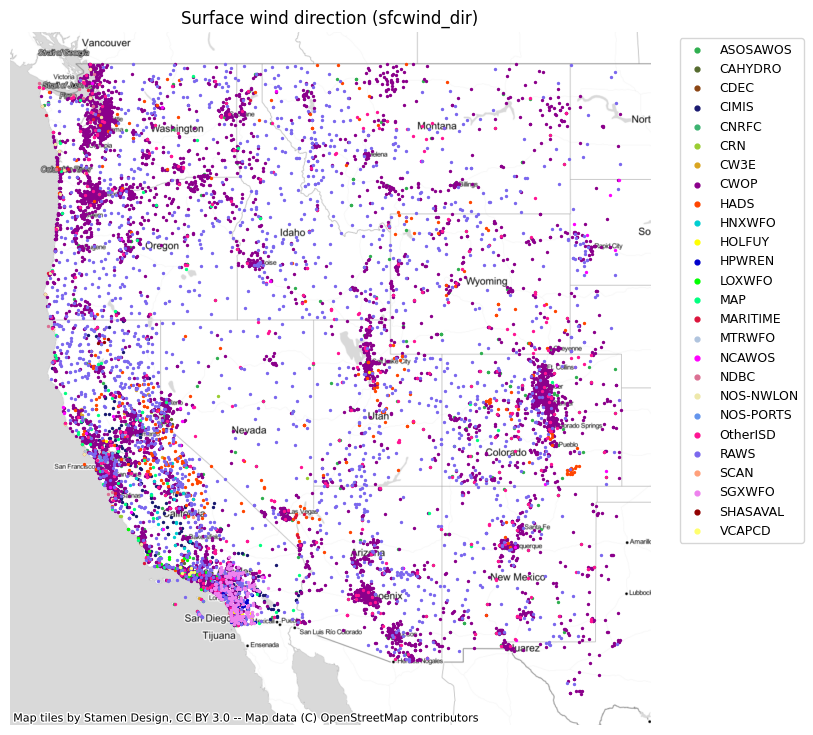

<Figure size 640x480 with 0 Axes>

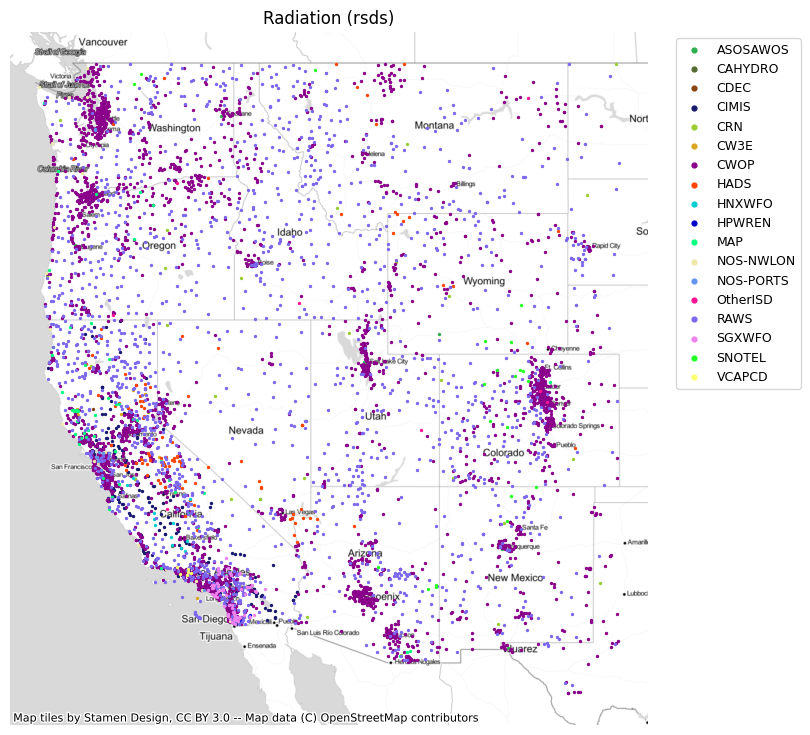

<Figure size 640x480 with 0 Axes>

In [28]:
# generate single maps for all variables
varlist = ['tas','tdps','tdps_derived', 
           'ps','psl','ps_altimeter', 
           'pr','pr_5min','pr_1h','pr_24h','pr_localmid',
           'hurs','sfcwind','sfcwind_dir','rsds']

for var in varlist:
    shapepath = "s3://wecc-historical-wx/0_maps/tl_2021_us_state.shp"
    single_var_map(var = var, shapepath = shapepath)

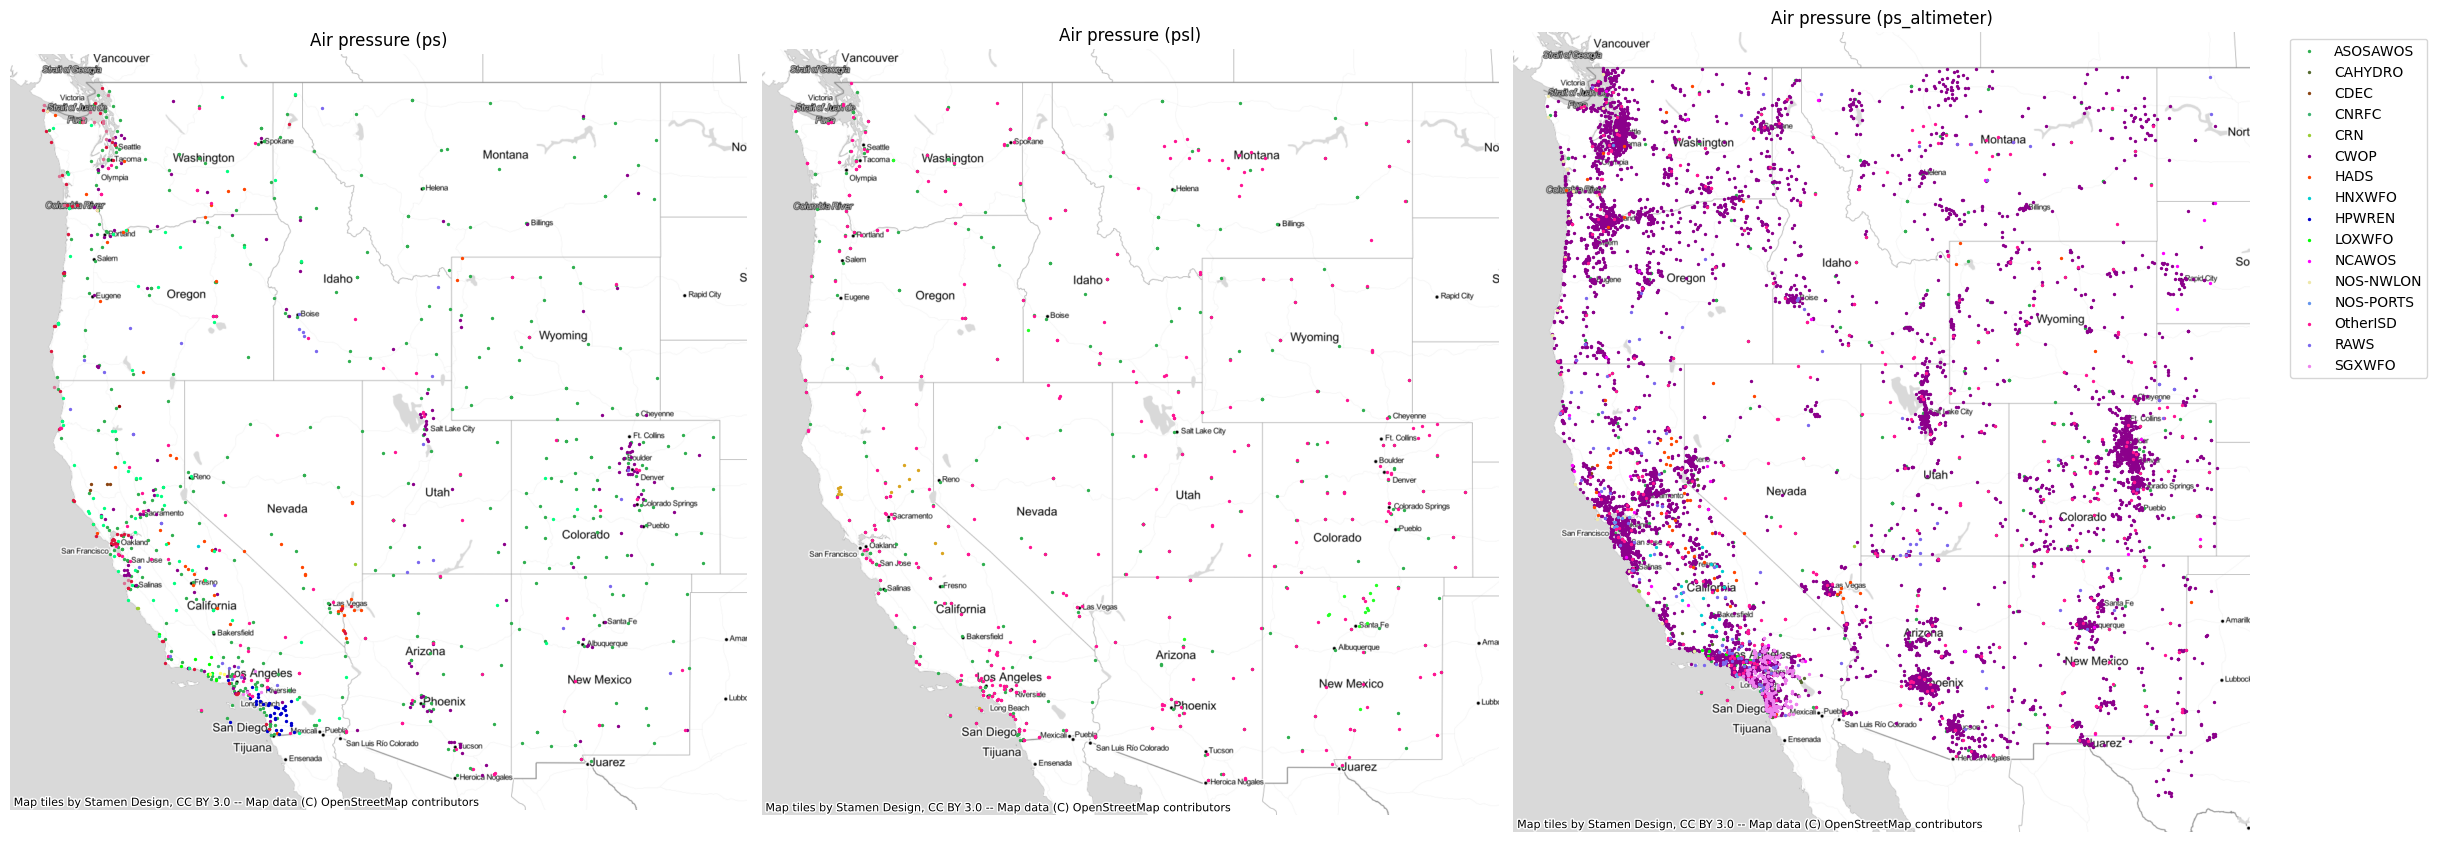

In [31]:
def combo_var_map(multi_var, shapepath):
    
    # set up    
    bucket_name = "wecc-historical-wx"
          
    # figure global settings
    a=1 # alpha
    ms=2 # markersize
    n=1
    
    # set up - determine how many vars are passed
    if len(multi_var) == 1: # single var passed
        single_var_map(multi_var[0], shapepath)

        
    elif len(multi_var)%2 == 0: # even number passed
        fig = plt.subplots(nrows=int((len(multi_var)/2)), ncols=2, figsize=(16,20))
        
        for var_to_plot in multi_var:
            ax = plt.subplot((len(multi_var)/2), 2, n)
            
            gdf = gdf_setup(var_to_plot, shapepath)
            
            # plot by network with correct legend color
            for ctype, data in gdf.groupby('network'):
                color = color_dict[ctype]
                data.plot(color=color,
                          markersize=ms, 
                          alpha=a,
                          ax=ax, 
                          label=ctype)

            cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite);

            # set title
            vartitle = var_fullname(var_to_plot)
            ax.set_title(vartitle, fontsize=12)
            ax.set_axis_off()

            n = n +1 # move to next axis
        
        
    elif len(multi_var)%3 == 0: # odd number passed
        fig = plt.subplots(nrows=int((len(multi_var)/3)), ncols=3, figsize=(24,20))
        for var_to_plot in multi_var:
            ax = plt.subplot(len(multi_var)/3, 3, n)
            
            gdf = gdf_setup(var_to_plot, shapepath)
            
            # plot by network with correct legend color
            for ctype, data in gdf.groupby('network'):
                color = color_dict[ctype]
                data.plot(color=color,
                          markersize=ms, 
                          alpha=a,
                          ax=ax, 
                          label=ctype)

            cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite);

            # set title
            vartitle = var_fullname(var_to_plot)
            ax.set_title(vartitle, fontsize=12)
            ax.set_axis_off()

            n = n +1 # move to next axis
        
    # unifed single legend
    l = plt.legend(bbox_to_anchor=(1.25, 1), frameon=True)
    
    # fix white spacing
    plt.tight_layout()

    # Save to AWS
    img_data = BytesIO()
    plt.savefig(img_data, format='png', bbox_inches='tight')
    img_data.seek(0)
    
    s3 = boto3.resource('s3')
    bucket = s3.Bucket(bucket_name)
    bucket.put_object(Body=img_data, ContentType='image/png', 
                      Key="2_clean_wx/clean_station_{}.png".format('_'.join(multi_var)))

# Run function to produce plots
shapepath = "s3://wecc-historical-wx/0_maps/tl_2021_us_state.shp"
combo_var_map(multi_var=['ps', 'psl', 'ps_altimeter'], shapepath=shapepath) # example of multiple vars passed

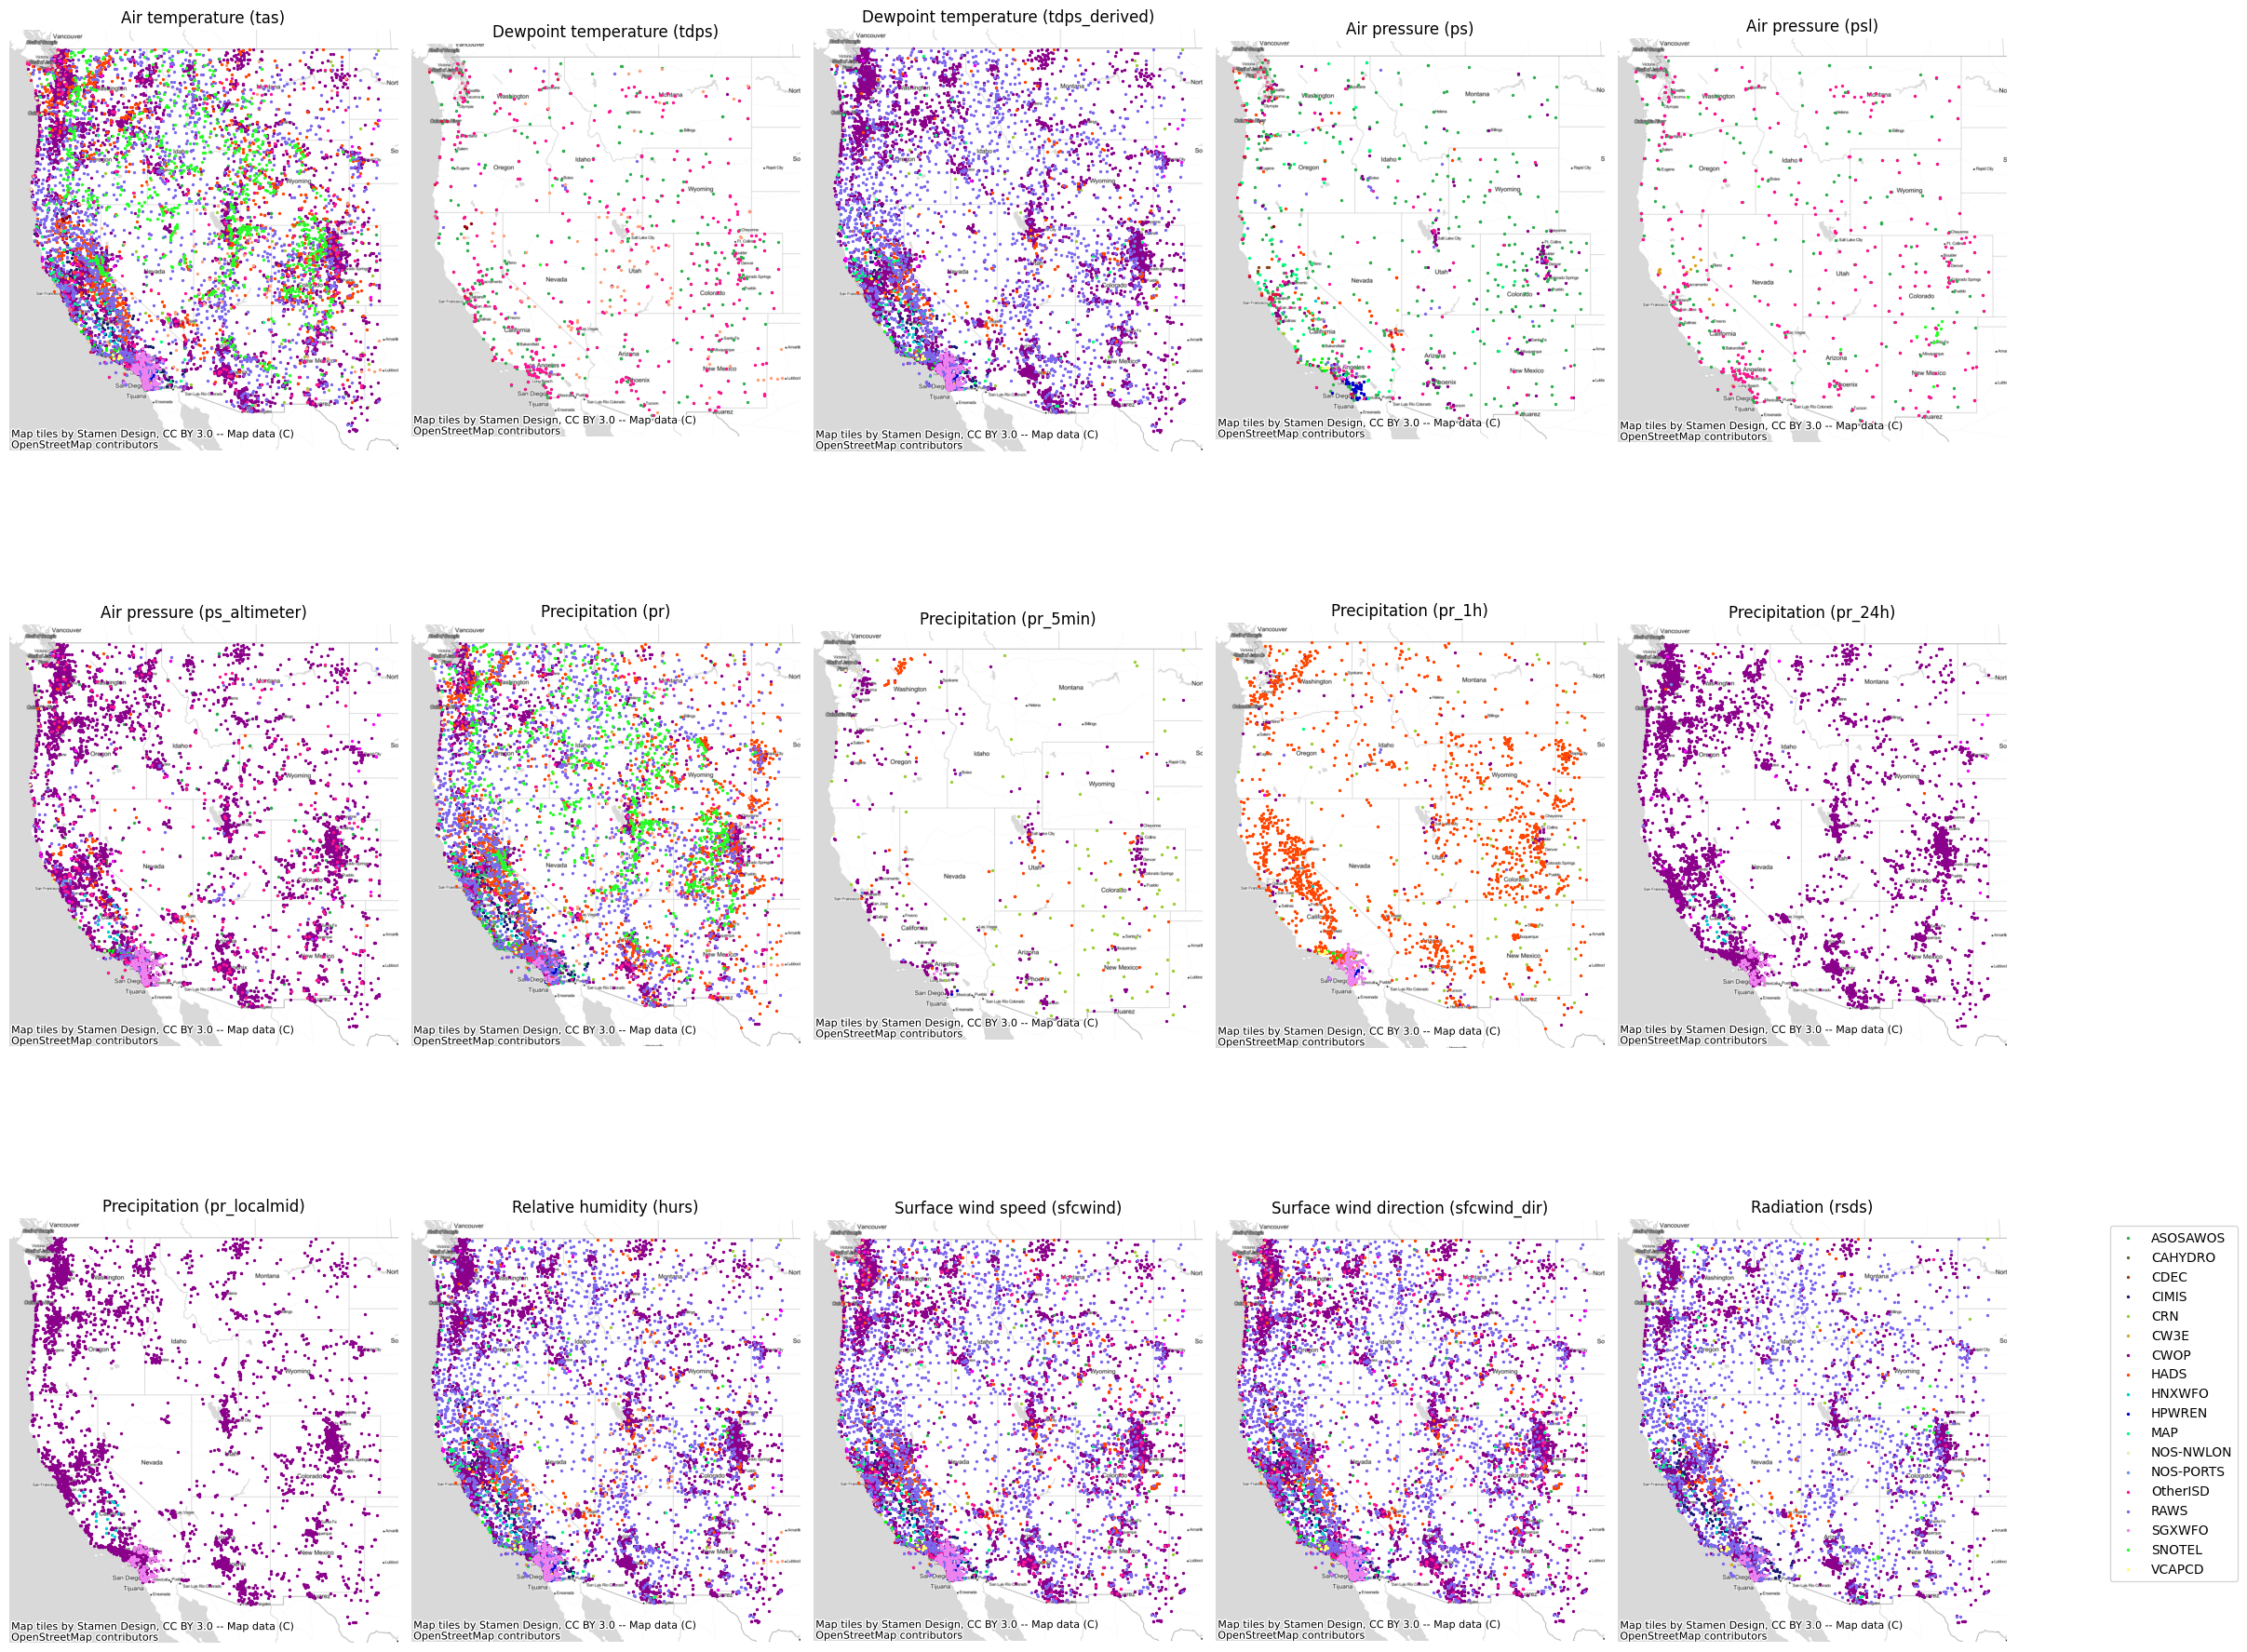

In [32]:
# 15 vars total
def plot_all_vars(var_list, shapepath):
    # set up    
    bucket_name = "wecc-historical-wx"
          
    # subplot global settings
    a=1 # alpha
    ms=2 # markersize
    n=1 # initialize plot counter
    
    fig = plt.subplots(nrows=3, ncols=5, figsize=(24,20))
    
    for var_to_plot in var_list:
        ax = plt.subplot(3,5,n)
        
        gdf = gdf_setup(var_to_plot, shapepath)

        # plot by network with correct legend color
        for ctype, data in gdf.groupby('network'):
            color = color_dict[ctype]
            data.plot(color=color,
                      markersize=ms, 
                      alpha=a,
                      ax=ax, 
                      label=ctype, 
                      legend=False)

        cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite);

        # set title
        vartitle = var_fullname(var_to_plot)
        ax.set_title(vartitle, fontsize=12)
        ax.set_axis_off()
                
        # move ot next subplot
        n = n + 1 
        
    # legend handling
    plt.legend(bbox_to_anchor=(1.25, 1), frameon=True) 
    
    # fix white spacing
    plt.tight_layout()
    
    # Save to AWS
    img_data = BytesIO()
    plt.savefig(img_data, format='png', bbox_inches='tight')
    img_data.seek(0)
    
    s3 = boto3.resource('s3')
    bucket = s3.Bucket(bucket_name)
    bucket.put_object(Body=img_data, ContentType='image/png', Key="2_clean_wx/clean_station_allvars.png")
        
# run function to produce plots
shapepath = "s3://wecc-historical-wx/0_maps/tl_2021_us_state.shp"
varlist = ['tas','tdps','tdps_derived', 
           'ps','psl','ps_altimeter', 
           'pr','pr_5min','pr_1h','pr_24h','pr_localmid',
           'hurs','sfcwind','sfcwind_dir','rsds']
plot_all_vars(varlist, shapepath)